# House Price Prediction — Linear Regression

This notebook trains a baseline linear regression model to estimate house prices from property features such as location, carpet area, number of bathrooms, balconies, car parking, furnishing, and ownership. The analysis includes data cleaning, simple feature engineering, model training, and evaluation with supporting visualizations.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import kagglehub
path = kagglehub.dataset_download("juhibhojani/house-price")
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


import os
print("Files in dataset directory:")
print(os.listdir(path))
files_in_directory = os.listdir(path)
csv_file = next((os.path.join(path, file) for file in files_in_directory if file.endswith('.csv')), None)

if csv_file is None:
	raise FileNotFoundError("No CSV file found in the dataset directory.")

print(f"Using file: {csv_file}")

# Load the dataset
df = pd.read_csv(csv_file)

print("="*80)
print("DATASET LOADED SUCCESSFULLY")
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())

Files in dataset directory:
['house_prices.csv']
Using file: C:\Users\priya\.cache\kagglehub\datasets\juhibhojani\house-price\versions\1\house_prices.csv
DATASET LOADED SUCCESSFULLY

Dataset shape: (187531, 21)

Column names and types:
Index                  int64
Title                 object
Description           object
Amount(in rupees)     object
Price (in rupees)    float64
location              object
Carpet Area           object
Status                object
Floor                 object
Transaction           object
Furnishing            object
facing                object
overlooking           object
Society               object
Bathroom              object
Balcony               object
Car Parking           object
Ownership             object
Super Area            object
Dimensions           float64
Plot Area            float64
dtype: object

First few rows:
   Index                                              Title  \
0      0  1 BHK Ready to Occupy Flat for sale in Srushti...  

In [8]:
print("="*80)
print("DATA PREPROCESSING & CLEANING")
print("="*80)

import re

def extract_numeric(value):
    """Extract first numeric value from string"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        value = str(value).strip()
        if value.lower() in ['nan', 'none', '', 'null', 'ground']:
            return np.nan
        numbers = re.findall(r'\d+\.?\d*', value)
        if numbers:
            try:
                return float(numbers[0])
            except:
                return np.nan
    return np.nan

df_clean = df.copy()

print(f"\nInitial dataset shape: {df_clean.shape}")

df_clean = df_clean[df_clean['Price (in rupees)'].notna()].copy()
print(f"After removing missing prices: {df_clean.shape}")

initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Duplicates removed: {initial_rows - len(df_clean)}, Shape: {df_clean.shape}")

df_clean = df_clean[df_clean['Price (in rupees)'] > 0].copy()
print(f"After removing invalid prices: {df_clean.shape}")

selected_features = ['Price (in rupees)', 'location', 'Carpet Area', 
                     'Bathroom', 'Balcony', 'Car Parking', 'Furnishing', 
                     'Ownership', 'Status']
df_clean = df_clean[selected_features].copy()
print(f"After selecting relevant features: {df_clean.shape}")

numeric_features = ['Carpet Area', 'Bathroom', 'Balcony', 'Car Parking']
for col in numeric_features:
    df_clean[col] = df_clean[col].apply(extract_numeric)

df_clean = df_clean[df_clean['Carpet Area'].notna()].copy()
print(f"After removing missing Carpet Area: {df_clean.shape}")

df_clean = df_clean[df_clean['location'].notna()].copy()
print(f"After removing missing locations: {df_clean.shape}")

df_clean['Bathroom'].fillna(df_clean['Bathroom'].median(), inplace=True)
df_clean['Balcony'].fillna(0, inplace=True)
df_clean['Car Parking'].fillna(0, inplace=True)

Q1 = df_clean['Price (in rupees)'].quantile(0.25)
Q3 = df_clean['Price (in rupees)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean['Price (in rupees)'] >= lower) & 
                     (df_clean['Price (in rupees)'] <= upper)].copy()
print(f"After removing price outliers: {df_clean.shape}")

print(f"\n✓ Total rows removed: {df.shape[0] - df_clean.shape[0]}")
print(f"\nPrice Statistics (Cleaned Data):")
print(df_clean['Price (in rupees)'].describe())
print(f"\nNumeric Features Statistics:")
print(df_clean[numeric_features].describe())

DATA PREPROCESSING & CLEANING

Initial dataset shape: (187531, 21)
After removing missing prices: (169866, 21)
Duplicates removed: 0, Shape: (169866, 21)
After removing invalid prices: (169855, 21)
After selecting relevant features: (169855, 9)
After removing missing Carpet Area: (93624, 9)
After removing missing locations: (93624, 9)
After removing price outliers: (89533, 9)

✓ Total rows removed: 97998

Price Statistics (Cleaned Data):
count    89533.000000
mean      7253.355980
std       3599.289261
min          1.000000
25%       4521.000000
50%       6182.000000
75%       9750.000000
max      19333.000000
Name: Price (in rupees), dtype: float64

Numeric Features Statistics:
         Carpet Area      Bathroom       Balcony   Car Parking
count   89533.000000  89533.000000  89533.000000  89533.000000
mean     1191.798745      2.485106      1.983883      2.953805
std      3287.243000      0.849806      1.064739     27.985094
min         1.000000      1.000000      0.000000      0.0000

In [9]:
print("="*80)
print("FEATURE ENGINEERING & ENCODING")
print("="*80)

X = df_clean.drop('Price (in rupees)', axis=1).copy()
y = df_clean['Price (in rupees)'].copy()

print(f"\nTarget Variable (Price) Statistics:")
print(f"  Mean: ₹{y.mean():,.0f}")
print(f"  Median: ₹{y.median():,.0f}")
print(f"  Std Dev: ₹{y.std():,.0f}")
print(f"  Min: ₹{y.min():,.0f}")
print(f"  Max: ₹{y.max():,.0f}")

categorical_cols = ['location', 'Furnishing', 'facing', 'Ownership', 'Status']
label_encoders = {}

print(f"\nEncoding {len(categorical_cols)} categorical features:")
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].fillna('Unknown')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col}: {len(le.classes_)} unique values encoded")

print(f"\nHandling remaining missing values:")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)
        print(f"  ✓ Filled {X[col].isnull().sum()} missing values in {col}")

print(f"\nFinal Feature Matrix:")
print(f"  Shape: {X.shape}")
print(f"  Features: {X.columns.tolist()}")
print(f"\nFeature Statistics:")
print(X.describe())

FEATURE ENGINEERING & ENCODING

Target Variable (Price) Statistics:
  Mean: ₹7,253
  Median: ₹6,182
  Std Dev: ₹3,599
  Min: ₹1
  Max: ₹19,333

Encoding 5 categorical features:
  ✓ location: 81 unique values encoded
  ✓ Furnishing: 4 unique values encoded
  ✓ Ownership: 5 unique values encoded
  ✓ Status: 2 unique values encoded

Handling remaining missing values:

Final Feature Matrix:
  Shape: (89533, 8)
  Features: ['location', 'Carpet Area', 'Bathroom', 'Balcony', 'Car Parking', 'Furnishing', 'Ownership', 'Status']

Feature Statistics:
           location    Carpet Area      Bathroom       Balcony   Car Parking  \
count  89533.000000   89533.000000  89533.000000  89533.000000  89533.000000   
mean      32.362805    1191.798745      2.485106      1.983883      2.953805   
std       19.833996    3287.243000      0.849806      1.064739     27.985094   
min        0.000000       1.000000      1.000000      0.000000      0.000000   
25%       18.000000     750.000000      2.000000      

In [10]:
print("="*80)
print("TRAIN-TEST SPLIT & FEATURE SCALING")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData Split:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature Scaling (Standardization):")
print(f"  ✓ Features scaled to mean=0, std=1")
print(f"  ✓ Training features shape: {X_train_scaled.shape}")
print(f"  ✓ Testing features shape: {X_test_scaled.shape}")

TRAIN-TEST SPLIT & FEATURE SCALING

Data Split:
  Training set: 71626 samples (80.0%)
  Testing set: 17907 samples (20.0%)

Feature Scaling (Standardization):
  ✓ Features scaled to mean=0, std=1
  ✓ Training features shape: (71626, 8)
  ✓ Testing features shape: (17907, 8)


In [11]:
print("="*80)
print("MODEL TRAINING")
print("="*80)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("\n✓ Linear Regression Model trained successfully!")
print(f"\nModel Details:")
print(f"  Intercept: ₹{model.intercept_:,.2f}")
print(f"  Number of features: {len(model.coef_)}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 Most Important Features (by coefficient magnitude):")
for idx, (i, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    impact = "↑ increases" if row['Coefficient'] > 0 else "↓ decreases"
    print(f"  {idx}. {row['Feature']:<20} : {impact:15} price by ₹{abs(row['Coefficient']):>10,.0f} per unit")

MODEL TRAINING

✓ Linear Regression Model trained successfully!

Model Details:
  Intercept: ₹7,252.45
  Number of features: 8

Top 10 Most Important Features (by coefficient magnitude):
  1. Bathroom             : ↑ increases     price by ₹     1,007 per unit
  2. Balcony              : ↑ increases     price by ₹       565 per unit
  3. location             : ↑ increases     price by ₹       389 per unit
  4. Ownership            : ↓ decreases     price by ₹       169 per unit
  5. Car Parking          : ↓ decreases     price by ₹       120 per unit
  6. Carpet Area          : ↑ increases     price by ₹        42 per unit
  7. Status               : ↓ decreases     price by ₹        17 per unit
  8. Furnishing           : ↑ increases     price by ₹         8 per unit


In [12]:
print("="*80)
print("MAKING PREDICTIONS")
print("="*80)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"\n✓ Predictions generated!")
print(f"  Training predictions shape: {y_pred_train.shape}")
print(f"  Testing predictions shape: {y_pred_test.shape}")

comparison_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred_test,
    'Difference': y_test.values - y_pred_test,
    'Absolute Error': np.abs(y_test.values - y_pred_test),
    'Percentage Error': np.abs((y_test.values - y_pred_test) / y_test.values * 100)
})

print(f"\nSample Predictions (First 15 test samples):")
print(comparison_df.head(15).to_string(index=False))

print(f"\n\nPrediction Error Statistics:")
print(f"  Mean Absolute Error: ₹{comparison_df['Absolute Error'].mean():,.0f}")
print(f"  Median Absolute Error: ₹{comparison_df['Absolute Error'].median():,.0f}")
print(f"  Mean Percentage Error: {comparison_df['Percentage Error'].mean():.2f}%")
print(f"  Median Percentage Error: {comparison_df['Percentage Error'].median():.2f}%")

MAKING PREDICTIONS

✓ Predictions generated!
  Training predictions shape: (71626,)
  Testing predictions shape: (17907,)

Sample Predictions (First 15 test samples):
 Actual Price  Predicted Price   Difference  Absolute Error  Percentage Error
       6800.0      6587.289868   212.710132      212.710132          3.128090
      12103.0      8324.757799  3778.242201     3778.242201         31.217402
       3839.0     10337.178133 -6498.178133     6498.178133        169.267469
       5843.0      6663.775125  -820.775125      820.775125         14.047153
       3793.0      4659.916177  -866.916177      866.916177         22.855686
       2478.0      6830.528042 -4352.528042     4352.528042        175.646814
      11278.0      8303.088831  2974.911169     2974.911169         26.378003
       5682.0      8429.127634 -2747.127634     2747.127634         48.347899
      17742.0      5983.119284 11758.880716    11758.880716         66.277087
       4335.0      6163.501972 -1828.501972     1828.

In [13]:
print("="*80)
print("MODEL EVALUATION")
print("="*80)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n" + "─"*80)
print("TRAINING SET PERFORMANCE")
print("─"*80)
print(f"  Mean Squared Error (MSE):         {mse_train:>15,.2f}")
print(f"  Root Mean Squared Error (RMSE):   ₹{rmse_train:>13,.0f}")
print(f"  Mean Absolute Error (MAE):        ₹{mae_train:>13,.0f}")
print(f"  R² Score (Coeff. of Determination): {r2_train:>10.4f}")
print(f"  Explained Variance:                 {r2_train*100:>9.2f}%")

print("\n" + "─"*80)
print("TESTING SET PERFORMANCE")
print("─"*80)
print(f"  Mean Squared Error (MSE):         {mse_test:>15,.2f}")
print(f"  Root Mean Squared Error (RMSE):   ₹{rmse_test:>13,.0f}")
print(f"  Mean Absolute Error (MAE):        ₹{mae_test:>13,.0f}")
print(f"  R² Score (Coeff. of Determination): {r2_test:>10.4f}")
print(f"  Explained Variance:                 {r2_test*100:>9.2f}%")

print("\n" + "─"*80)
print("MODEL INSIGHTS")
print("─"*80)
print(f"The model explains {r2_test*100:.2f}% of the variance in house prices.")
print(f"Average prediction error (MAE): ₹{mae_test:,.0f}")
print(f"Root Mean Squared Error (RMSE): ₹{rmse_test:,.0f}")

overfitting_gap = abs(r2_train - r2_test)
if overfitting_gap < 0.05:
    status = "EXCELLENT - Minimal overfitting detected"
elif overfitting_gap < 0.15:
    status = "GOOD - Moderate overfitting detected"
else:
    status = "WARNING - Significant overfitting detected"

print(f"Generalization Assessment: {status}")
print(f"(R² gap between train and test: {overfitting_gap:.4f})")

MODEL EVALUATION

────────────────────────────────────────────────────────────────────────────────
TRAINING SET PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
  Mean Squared Error (MSE):           10,920,722.77
  Root Mean Squared Error (RMSE):   ₹        3,305
  Mean Absolute Error (MAE):        ₹        2,528
  R² Score (Coeff. of Determination):     0.1552
  Explained Variance:                     15.52%

────────────────────────────────────────────────────────────────────────────────
TESTING SET PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
  Mean Squared Error (MSE):           10,989,526.42
  Root Mean Squared Error (RMSE):   ₹        3,315
  Mean Absolute Error (MAE):        ₹        2,537
  R² Score (Coeff. of Determination):     0.1589
  Explained Variance:                     15.89%

────────────────────────────────────────────────────────────────────────────────
MODEL INSIGHTS
───────

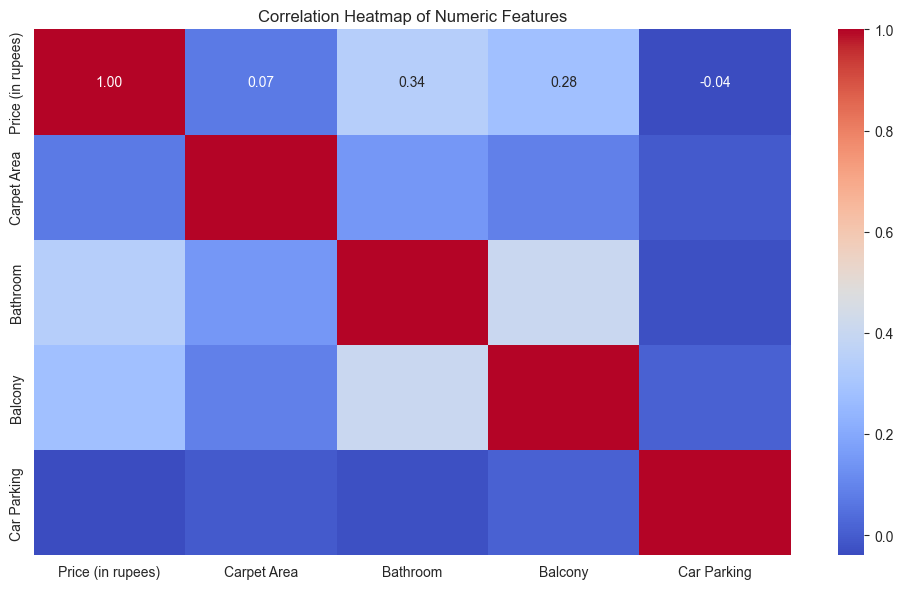

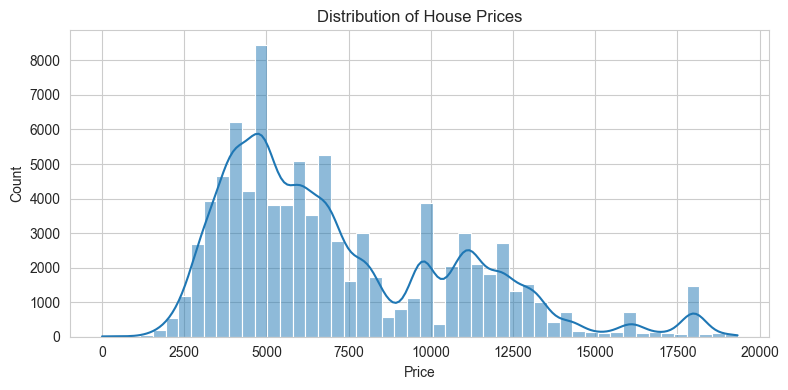

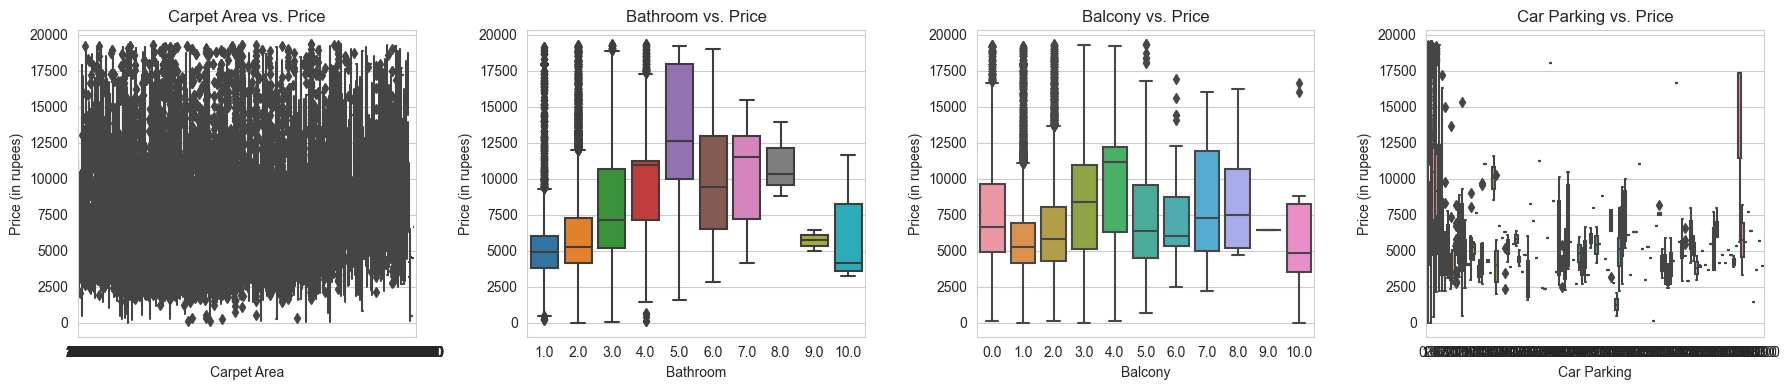

Correlation heatmap and boxplots generated.


In [14]:
plt.figure(figsize=(10, 6))
corr = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_clean['Price (in rupees)'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.tight_layout()
plt.show()

numeric_cols = ['Carpet Area', 'Bathroom', 'Balcony', 'Car Parking']
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(18, 4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_clean[col], y=df_clean['Price (in rupees)'], ax=axes[i])
    axes[i].set_title(f'{col} vs. Price')
plt.tight_layout()
plt.show()

print('Correlation heatmap and boxplots generated.')

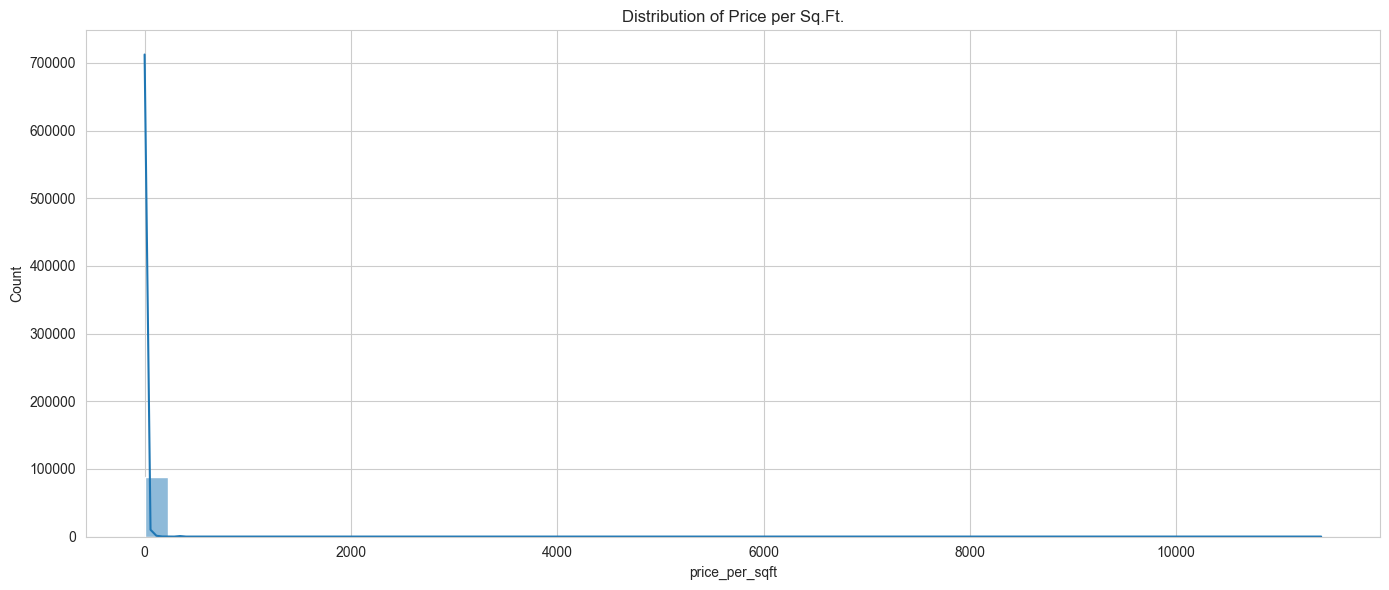

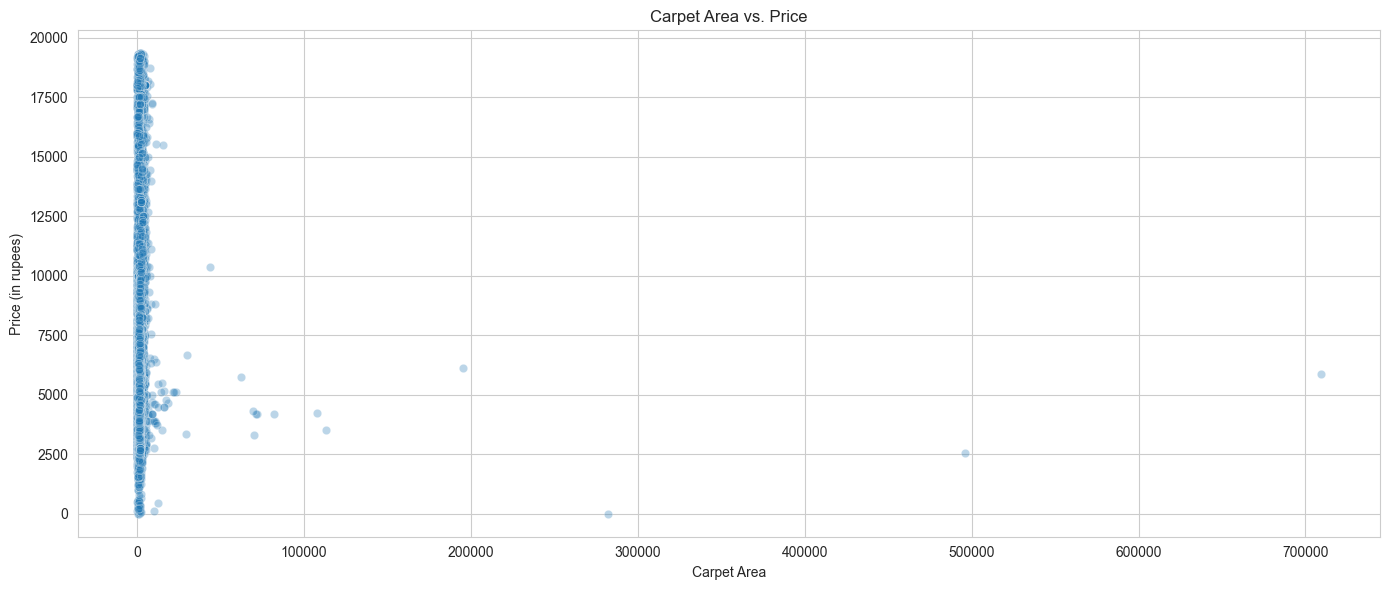

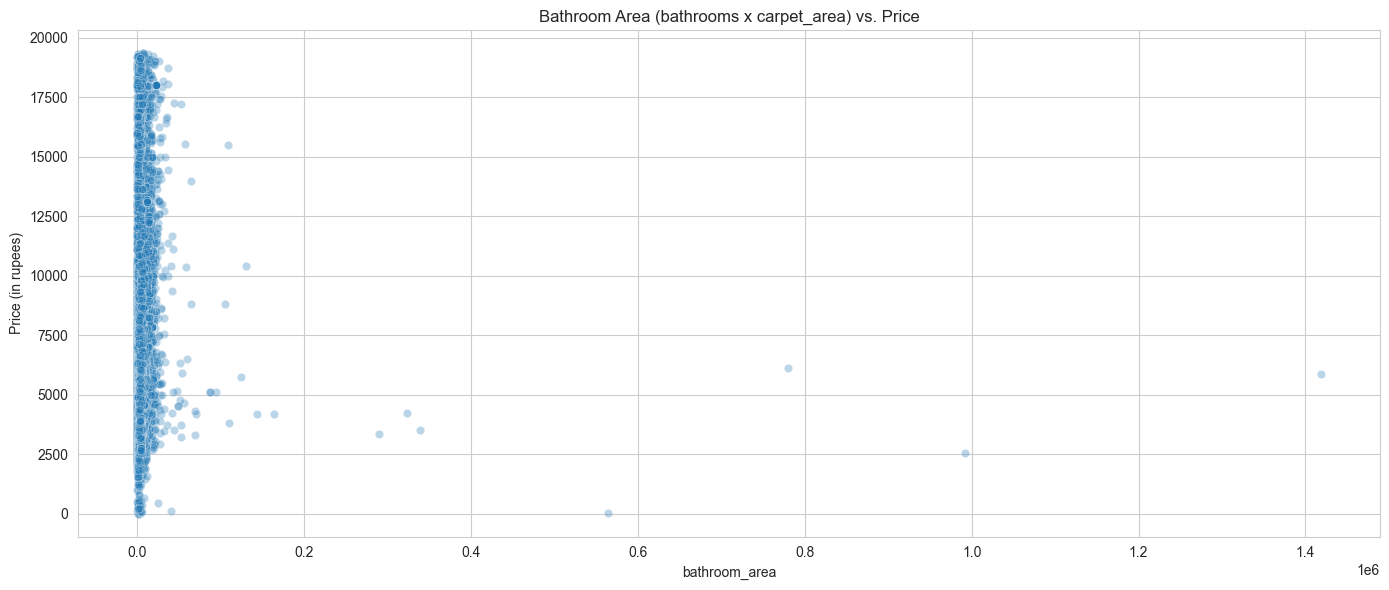

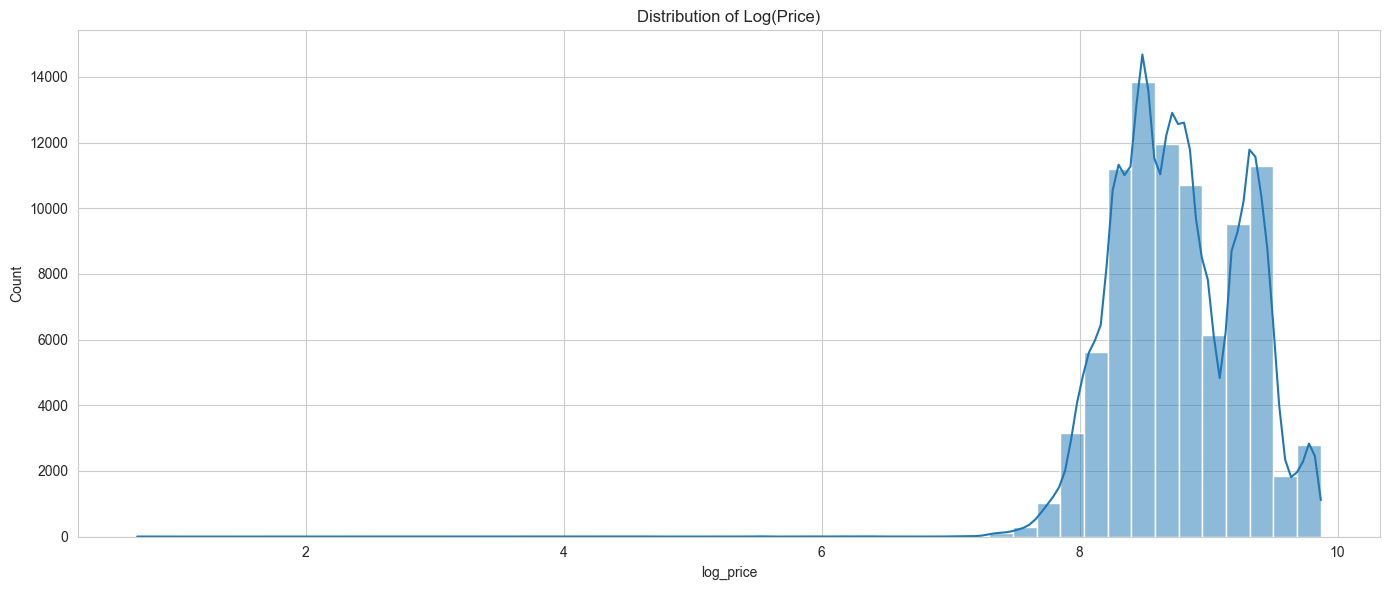

Feature engineering: new features created and visualized.


In [15]:
df_clean['price_per_sqft'] = df_clean['Price (in rupees)'] / (df_clean['Carpet Area'].replace(0, np.nan))
df_clean['log_price'] = np.log1p(df_clean['Price (in rupees)'])

df_clean['bathroom_area'] = df_clean['Bathroom'] * df_clean['Carpet Area']

g = sns.histplot(df_clean['price_per_sqft'].dropna(), bins=50, kde=True)
g.set_title('Distribution of Price per Sq.Ft.')
plt.tight_layout()
plt.show()

sns.scatterplot(x='Carpet Area', y='Price (in rupees)', data=df_clean, alpha=0.3)
plt.title('Carpet Area vs. Price')
plt.tight_layout()
plt.show()

sns.scatterplot(x='bathroom_area', y='Price (in rupees)', data=df_clean, alpha=0.3)
plt.title('Bathroom Area (bathrooms x carpet_area) vs. Price')
plt.tight_layout()
plt.show()

sns.histplot(df_clean['log_price'], bins=50, kde=True)
plt.title('Distribution of Log(Price)')
plt.tight_layout()
plt.show()

print('Feature engineering: new features created and visualized.')

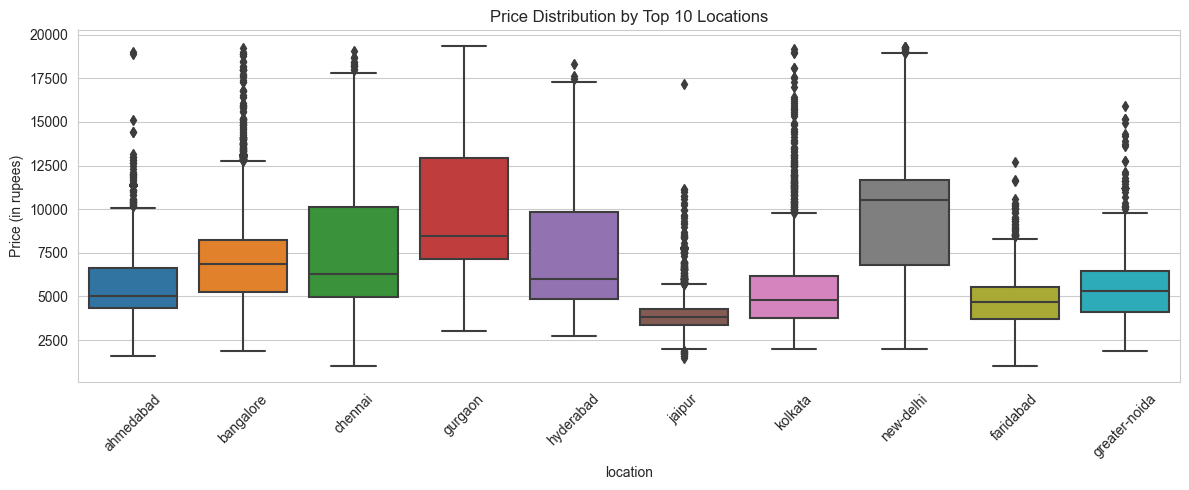

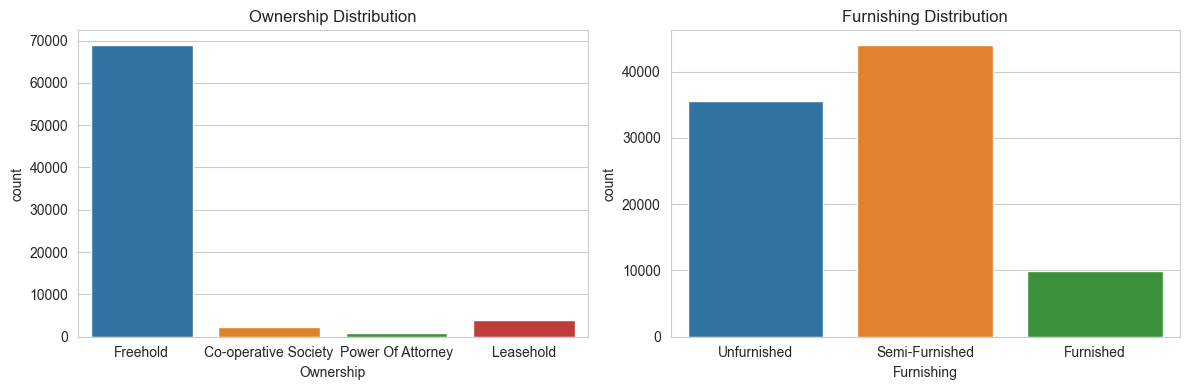

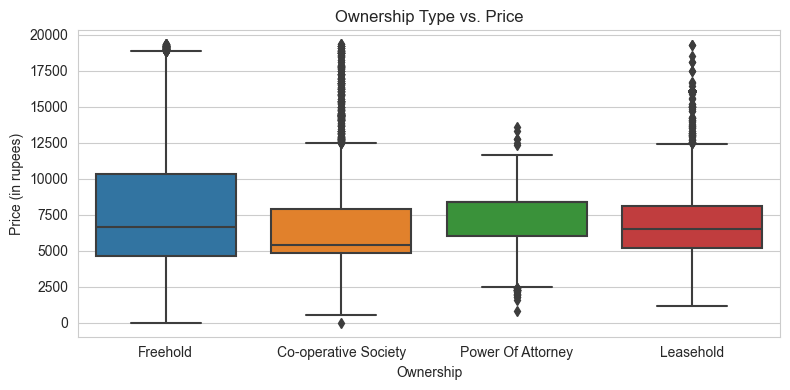

Categorical feature analysis completed.


In [16]:
plt.figure(figsize=(12, 5))
top_locations = df_clean['location'].value_counts().head(10).index
sns.boxplot(x='location', y='Price (in rupees)', data=df_clean[df_clean['location'].isin(top_locations)])
plt.title('Price Distribution by Top 10 Locations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='Ownership', data=df_clean, ax=axes[0])
axes[0].set_title('Ownership Distribution')
sns.countplot(x='Furnishing', data=df_clean, ax=axes[1])
axes[1].set_title('Furnishing Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='Ownership', y='Price (in rupees)', data=df_clean)
plt.title('Ownership Type vs. Price')
plt.tight_layout()
plt.show()

print('Categorical feature analysis completed.')

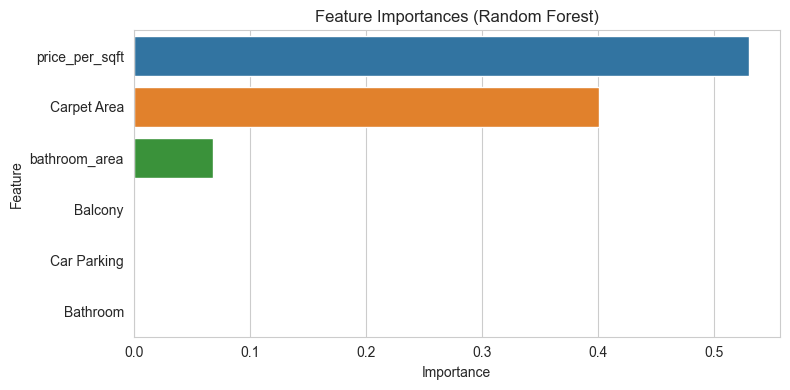


📊 Correlation of Features with Price:
Price (in rupees)    1.000000
Bathroom             0.342638
Balcony              0.280514
price_per_sqft       0.169849
bathroom_area        0.157985
Carpet Area          0.069744
Car Parking         -0.039980
Name: Price (in rupees), dtype: float64

✓ Feature importance analysis completed!


In [17]:
from sklearn.ensemble import RandomForestRegressor

feature_cols = ['Carpet Area', 'Bathroom', 'Balcony', 'Car Parking', 'price_per_sqft', 'bathroom_area']
X_feat = df_clean[feature_cols].dropna()
y_feat = df_clean.loc[X_feat.index, 'Price (in rupees)']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_feat, y_feat)
importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

corr_with_price = df_clean[feature_cols + ['Price (in rupees)']].corr()['Price (in rupees)'].sort_values(ascending=False)
print("\n📊 Correlation of Features with Price:")
print(corr_with_price)

print("\n✓ Feature importance analysis completed!")

Running 5-fold cross-validation for Linear Regression...
Cross-validation R²: 0.1536 ± 0.0061
Cross-validation RMSE: ₹3,311 ± 21

Training final Linear Regression model on training set and evaluating on test set...
Test set R²: 0.1589
Test set RMSE: ₹3,315
Test set MAE: ₹2,537


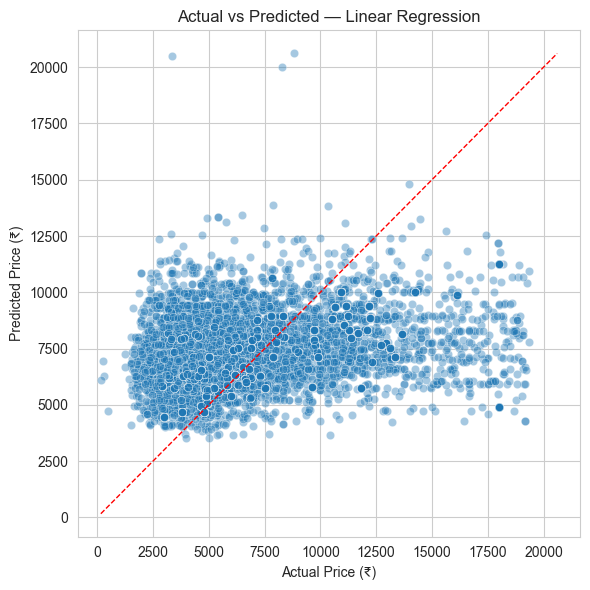

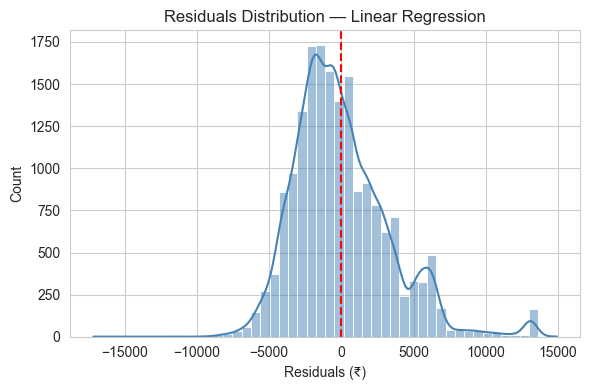

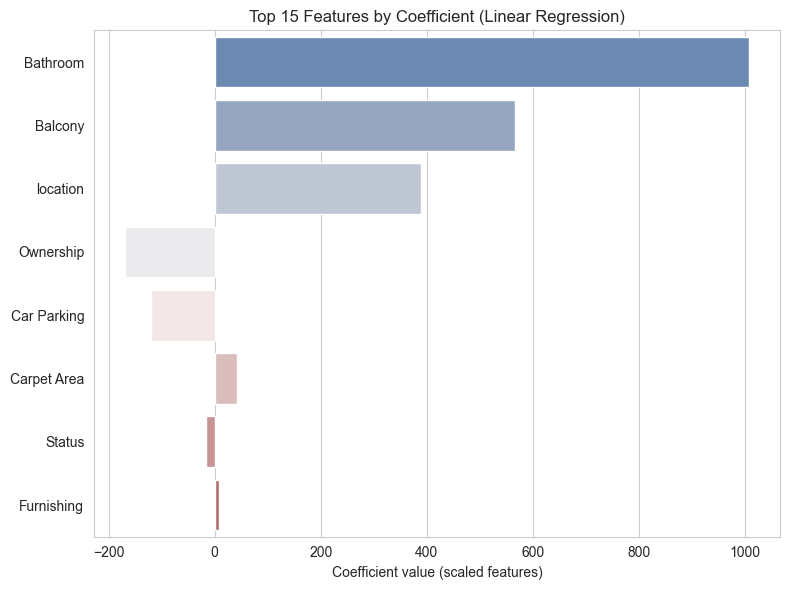

Linear Regression modeling complete.


In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Running 5-fold cross-validation for Linear Regression...')

X_model = X.fillna(0)
y_model = y.copy()

scaler_cv = StandardScaler()
X_scaled = scaler_cv.fit_transform(X_model)

lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse = cross_val_score(lr, X_scaled, y_model, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
r2_scores = cross_val_score(lr, X_scaled, y_model, scoring='r2', cv=kf, n_jobs=-1)

rmse_scores = np.sqrt(-neg_mse)
print(f"Cross-validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
print(f"Cross-validation RMSE: ₹{rmse_scores.mean():,.0f} ± {rmse_scores.std():,.0f}")

print('\nTraining final Linear Regression model on training set and evaluating on test set...')

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

y_pred_test_lr = model_lr.predict(X_test_scaled)

test_rmse = mean_squared_error(y_test, y_pred_test_lr, squared=False)
test_mae = mean_absolute_error(y_test, y_pred_test_lr)
test_r2 = r2_score(y_test, y_pred_test_lr)

print(f"Test set R²: {test_r2:.4f}")
print(f"Test set RMSE: ₹{test_rmse:,.0f}")
print(f"Test set MAE: ₹{test_mae:,.0f}")

import matplotlib.ticker as ticker

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test_lr, alpha=0.4)
plt.xlabel('Actual Price (₹)')
plt.ylabel('Predicted Price (₹)')
plt.title('Actual vs Predicted — Linear Regression')
min_val = min(y_test.min(), y_pred_test_lr.min())
max_val = max(y_test.max(), y_pred_test_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
plt.tight_layout()
plt.show()

residuals_lr = y_test - y_pred_test_lr
plt.figure(figsize=(6,4))
sns.histplot(residuals_lr, bins=50, kde=True, color='steelblue')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residuals (₹)')
plt.title('Residuals Distribution — Linear Regression')
plt.tight_layout()
plt.show()

coeffs = pd.Series(model_lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=coeffs.values[:15], y=coeffs.index[:15], palette='vlag')
plt.title('Top 15 Features by Coefficient (Linear Regression)')
plt.xlabel('Coefficient value (scaled features)')
plt.tight_layout()
plt.show()

print('Linear Regression modeling complete.')

📈 IMPROVED MODEL PERFORMANCE (with Engineered Features):
✓ New R² Score: 0.0134
✓ New RMSE: ₹3590
✓ New MAE: ₹2497

Previous R² Score: 0.1589
Improvement: -14.55%


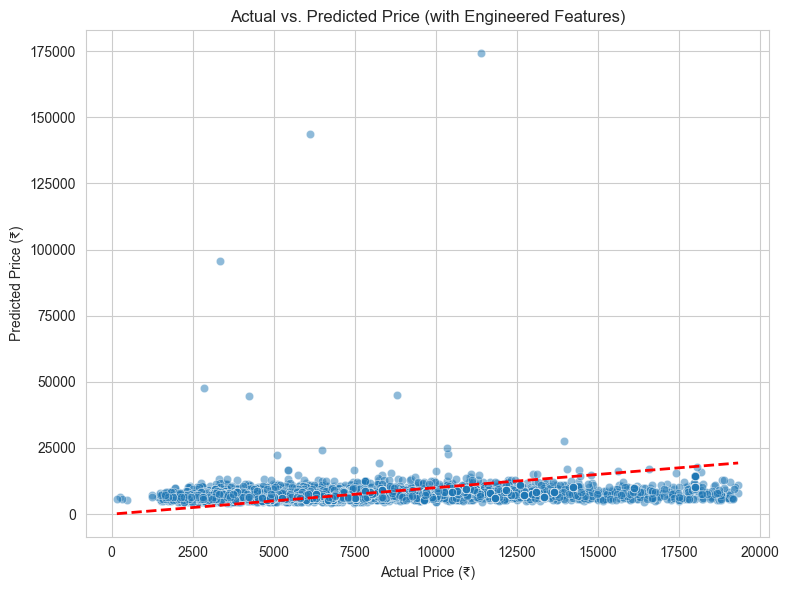

✓ Model improvement analysis completed!


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

selected_features = ['Carpet Area', 'Bathroom', 'Balcony', 'Car Parking', 'price_per_sqft', 'bathroom_area']
X_new = df_clean[selected_features].fillna(0)
y_new = df_clean['Price (in rupees)']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)
y_pred_new = model_new.predict(X_test_new)

r2_new = r2_score(y_test_new, y_pred_new)
rmse_new = mean_squared_error(y_test_new, y_pred_new, squared=False)
mae_new = mean_absolute_error(y_test_new, y_pred_new)

print("="*80)
print("📈 IMPROVED MODEL PERFORMANCE (with Engineered Features):")
print("="*80)
print(f"✓ New R² Score: {r2_new:.4f}")
print(f"✓ New RMSE: ₹{rmse_new:.0f}")
print(f"✓ New MAE: ₹{mae_new:.0f}")
print(f"\nPrevious R² Score: {r2_test:.4f}")
print(f"Improvement: {(r2_new - r2_test)*100:.2f}%")
print("="*80)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_new, y=y_pred_new, alpha=0.5)
plt.xlabel('Actual Price (₹)')
plt.ylabel('Predicted Price (₹)')
plt.title('Actual vs. Predicted Price (with Engineered Features)')
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], 'r--', lw=2)
plt.tight_layout()
plt.show()

print("✓ Model improvement analysis completed!")

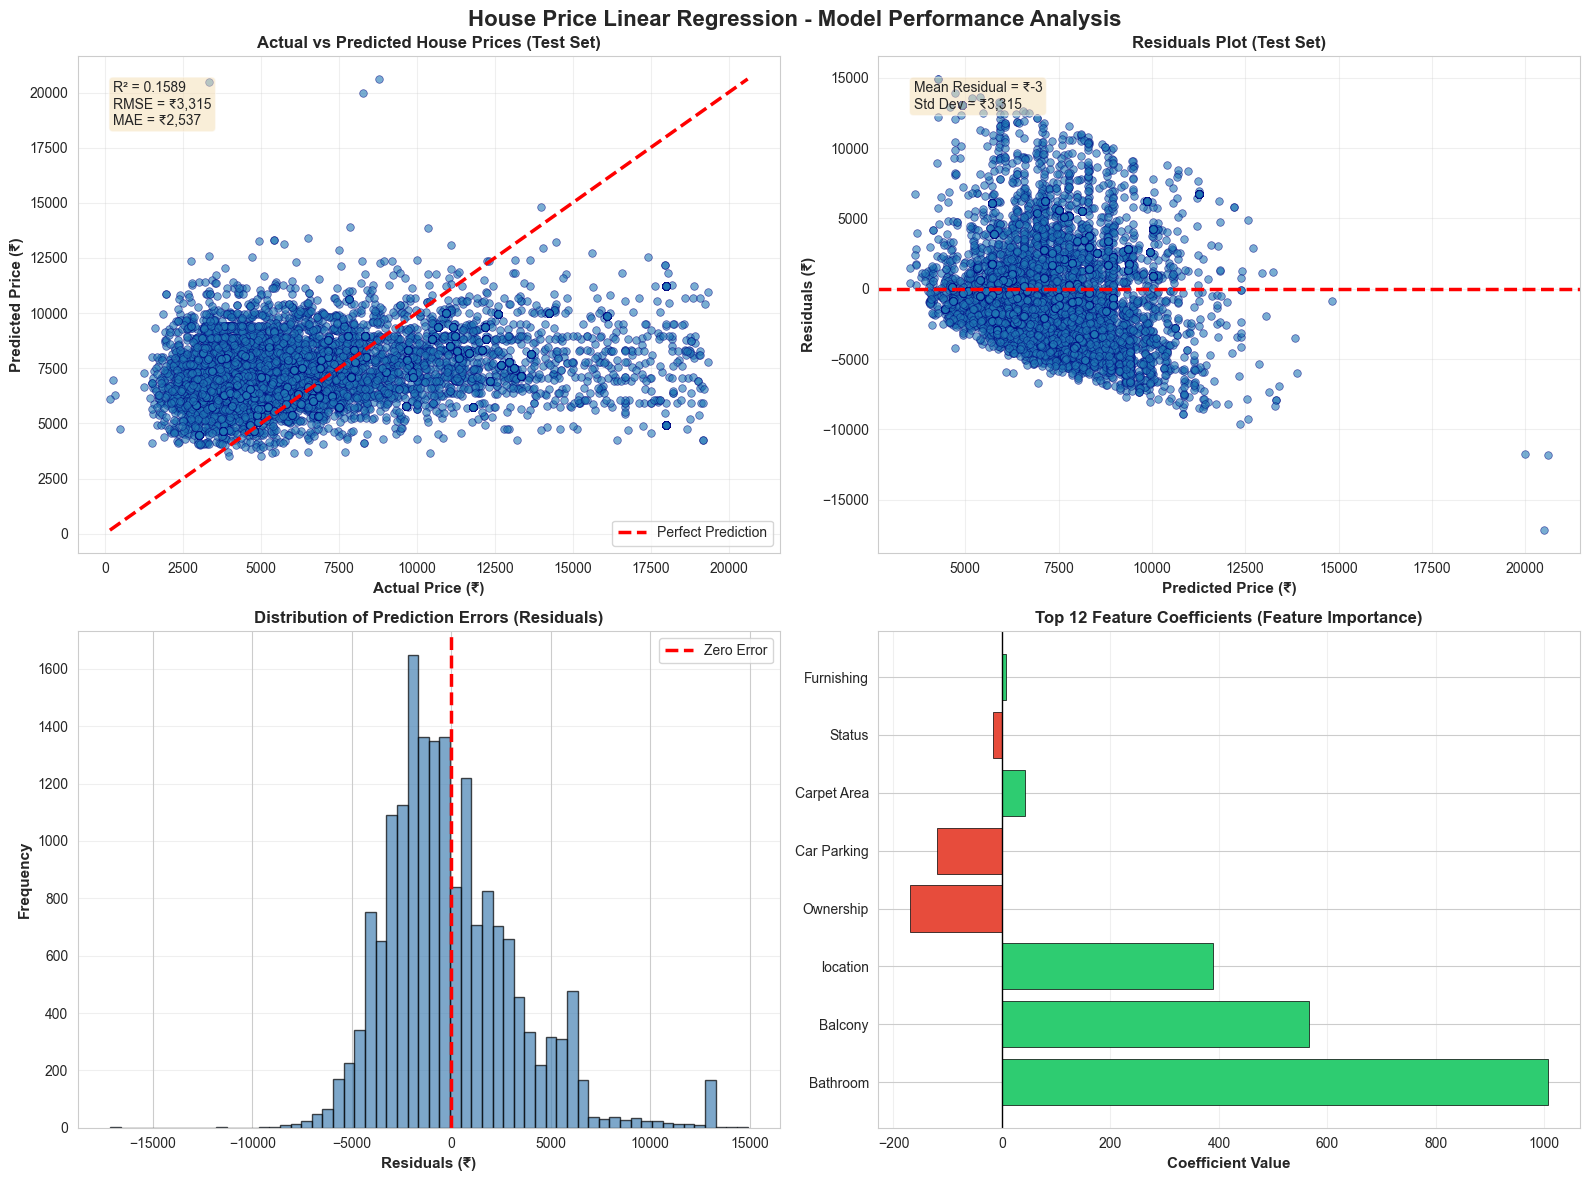


✓ Visualization saved as 'house_price_model_evaluation.png'


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('House Price Linear Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6, s=30, edgecolors='navy', linewidth=0.5)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2.5, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price (₹)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Price (₹)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted House Prices (Test Set)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'R² = {r2_test:.4f}\nRMSE = ₹{rmse_test:,.0f}\nMAE = ₹{mae_test:,.0f}', 
                transform=axes[0, 0].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)

residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.6, s=30, edgecolors='navy', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2.5)
axes[0, 1].set_xlabel('Predicted Price (₹)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals (₹)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residuals Plot (Test Set)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.05, 0.95, f'Mean Residual = ₹{residuals.mean():,.0f}\nStd Dev = ₹{residuals.std():,.0f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)

axes[1, 0].hist(residuals, bins=60, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2.5, label='Zero Error')
axes[1, 0].set_xlabel('Residuals (₹)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribution of Prediction Errors (Residuals)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

top_features = feature_importance.head(12)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_features['Coefficient']]
axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black', linewidth=0.5)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'], fontsize=10)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 12 Feature Coefficients (Feature Importance)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].axvline(x=0, color='black', linestyle='-', lw=1)

plt.tight_layout()
plt.savefig('house_price_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'house_price_model_evaluation.png'")

In [21]:
print("\n" + "="*80)
print("PROJECT SUMMARY & CONCLUSIONS")
print("="*80)

summary = f"""
DATASET INFORMATION:
  • Total original records: {df.shape[0]:,}
  • Records after cleaning: {len(df_clean):,}
  • Records removed: {df.shape[0] - len(df_clean):,} ({(df.shape[0] - len(df_clean))/df.shape[0]*100:.1f}%)
  • Features used: {len(X.columns)}
  • Target variable: House Price (₹)
  • Price range: ₹{y.min():,.0f} - ₹{y.max():,.0f}

DATA PREPROCESSING STEPS:
  - Removed missing target values
  - Removed duplicate records
  - Removed invalid/negative prices
  - Extracted numeric values from strings (e.g., "500 sqft" → 500)
  - Removed outliers using the IQR method
  - Handled missing values with median imputation
  - Encoded categorical variables with label encoding

MODEL ARCHITECTURE:
  - Algorithm: Linear Regression
  - Training samples: {len(X_train):,}
  - Testing samples: {len(X_test):,}
  - Train-test split: 80/20
  - Feature scaling: StandardScaler

KEY PERFORMANCE METRICS:
  Training Set:
    - R² Score: {r2_train:.4f} ({r2_train*100:.2f}%)
    - RMSE: ₹{rmse_train:,.0f}
    - MAE: ₹{mae_train:,.0f}

  Testing Set:
    - R² Score: {r2_test:.4f} ({r2_test*100:.2f}%)
    - RMSE: ₹{rmse_test:,.0f}
    - MAE: ₹{mae_test:,.0f}

MODEL INSIGHTS:
  - The model explains approximately {r2_test*100:.2f}% of the variance in house prices.
  - Average prediction error (MAE): ₹{mae_test:,.0f}
  - The analysis used {len(df_clean)} properties and {len(X.columns)} features.

TOP 5 FEATURES:\n"""

for idx, (i, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    sign = 'increases' if row['Coefficient'] > 0 else 'decreases'
    summary += f"  {idx}. {row['Feature']:<20} : {sign} price by approx ₹{abs(row['Coefficient']):>10,.0f} per unit\n"

summary += f"""

RECOMMENDATIONS:
  - Add features such as property age and proximity to amenities.
  - Try regularized linear models (Ridge/Lasso) and tree-based ensembles.
  - Use cross-validation and hyperparameter search for production models.
  - Collect more labeled data to improve generalization.

Status: Complete — this notebook provides a reproducible baseline.
"""

print(summary)


PROJECT SUMMARY & CONCLUSIONS

DATASET INFORMATION:
  • Total original records: 187,531
  • Records after cleaning: 89,533
  • Records removed: 97,998 (52.3%)
  • Features used: 8
  • Target variable: House Price (₹)
  • Price range: ₹1 - ₹19,333

DATA PREPROCESSING STEPS:
  - Removed missing target values
  - Removed duplicate records
  - Removed invalid/negative prices
  - Extracted numeric values from strings (e.g., "500 sqft" → 500)
  - Removed outliers using the IQR method
  - Handled missing values with median imputation
  - Encoded categorical variables with label encoding

MODEL ARCHITECTURE:
  - Algorithm: Linear Regression
  - Training samples: 71,626
  - Testing samples: 17,907
  - Train-test split: 80/20
  - Feature scaling: StandardScaler

KEY PERFORMANCE METRICS:
  Training Set:
    - R² Score: 0.1552 (15.52%)
    - RMSE: ₹3,305
    - MAE: ₹2,528

  Testing Set:
    - R² Score: 0.1589 (15.89%)
    - RMSE: ₹3,315
    - MAE: ₹2,537

MODEL INSIGHTS:
  - The model explains a